# File to complete data ingestion with PyTorch's `dataset` and `DataLoader` directly from NetCDF file.

In [7]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import List, Optional, Tuple

In [5]:
DATASET_PATH = Path("data/IberFire.nc")


In [11]:
class SpatioTemporalDataset(Dataset):
    """
    A PyTorch Dataset for spatio-temporal data stored in a NetCDF file.

    Each sample:
        - inputs: sequence of past time steps (T, C, H, W)
        - target: target variable at the *next* time step (H, W)

    Spatially, the domain is split into non-overlapping patches of size (patch_size x patch_size).
    """

    def __init__(
        self,
        data_path: Path,
        sequence_length: int = 30,
        stride: int = 1,
        patch_size: int = 64,
        target_variable: str = "is_near_fire",
        predictor_variables: Optional[List[str]] = None,
    ):
        """
        Parameters
        ----------
        data_path : Path
            Path to the NetCDF file.
        sequence_length : int
            Number of past time steps T in each input sequence.
        stride : int
            Step in time between the starts of consecutive sequences.
        patch_size : int
            Height/width of each square patch (in grid cells).
        target_variable : str
            Name of the variable to predict at the next time step.
        predictor_variables : list of str, optional
            Variables to use as input channels.
            If None, uses all data variables except the target.
        """
        self.data_path = Path(data_path)
        self.sequence_length = sequence_length
        self.stride = stride
        self.patch_size = patch_size
        self.target_variable = target_variable

        # IMPORTANT: open without chunks → simpler, each __getitem__ does a small read
        # You can add engine="h5netcdf" if needed
        self.ds = xr.open_dataset(self.data_path, decode_times=True)

        # Basic dimension info
        self.time_len = int(self.ds.sizes["time"])
        self.y_len = int(self.ds.sizes["y"])
        self.x_len = int(self.ds.sizes["x"])

        # Choose predictor variables
        if predictor_variables is None:
            self.predictor_variables = [
                v for v in self.ds.data_vars if v != self.target_variable
            ]
        else:
            self.predictor_variables = predictor_variables

        # Precompute how many patches fit in y/x
        self.n_patches_y = self.y_len // self.patch_size  # floor
        self.n_patches_x = self.x_len // self.patch_size  # floor

        # How many valid time windows?
        # We use times [t0, ..., t0+T-1] as inputs, and time t_target = t0+T as target.
        # Need t_target < time_len  →  t0 <= time_len - T - 1
        max_t0 = self.time_len - self.sequence_length - 1
        if max_t0 < 0:
            raise ValueError("sequence_length is too long for the available time dimension.")

        self.n_time_windows = (max_t0 // self.stride) + 1

        # Total samples = time_windows * patches_y * patches_x
        self._len = self.n_time_windows * self.n_patches_y * self.n_patches_x

    def __len__(self) -> int:
        return self._len

    def _index_to_coords(self, idx: int) -> Tuple[int, int, int, slice, slice]:
        """
        Map a flat dataset index to:
          - t0, t1: start/end of input sequence in time
          - t_target: time index for target (next step after sequence)
          - y_slice, x_slice: patch slice in space
        """
        if idx < 0 or idx >= self._len:
            raise IndexError(idx)

        patches_per_time = self.n_patches_y * self.n_patches_x

        # which time window?
        time_idx = idx // patches_per_time
        patch_idx = idx % patches_per_time

        # time indices
        t0 = time_idx * self.stride
        t1 = t0 + self.sequence_length
        t_target = t1  # next time step after the sequence

        # which patch in y/x?
        py = patch_idx // self.n_patches_x
        px = patch_idx % self.n_patches_x

        y0 = py * self.patch_size
        y1 = y0 + self.patch_size
        x0 = px * self.patch_size
        x1 = x0 + self.patch_size

        y_slice = slice(y0, y1)
        x_slice = slice(x0, x1)

        return t0, t1, t_target, y_slice, x_slice

    def __getitem__(self, idx: int):
        t0, t1, t_target, y_slice, x_slice = self._index_to_coords(idx)

        # ---- Inputs: (T, C, H, W) ----
        # Take selected predictor variables, slice in time and space
        # ds[predictor_variables] is a Dataset; to_array() gives DataArray with
        # dims: (variable, time, y, x)
        window_ds = self.ds[self.predictor_variables].isel(
            time=slice(t0, t1),
            y=y_slice,
            x=x_slice,
        )
        window_da = window_ds.to_array("channel")  # dims: (channel, time, y, x)
        window_da = window_da.transpose("time", "channel", "y", "x")
        x_np = window_da.values.astype("float32")  # (T, C, H, W)

        # ---- Target: (H, W) ----
        target_da = self.ds[self.target_variable].isel(
            time=t_target,
            y=y_slice,
            x=x_slice,
        )
        y_np = target_da.values.astype("float32")  # (H, W)

        # Convert to torch tensors
        x = torch.from_numpy(x_np)  # (T, C, H, W)
        y = torch.from_numpy(y_np)  # (H, W)

        sample = {
            "inputs": x,
            "target": y,
            "t0": t0,
        }
        return sample

In [12]:
from torch.utils.data import DataLoader

dataset = SpatioTemporalDataset(
    data_path=DATASET_PATH,
    sequence_length=16,
    stride=1,
    patch_size=64,
    target_variable="is_near_fire",
    predictor_variables=["CLC_2006_forest_proportion", "wind_speed_mean", "t2m_mean", "RH_mean", "total_precipitation_mean"], 
)

loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,    # keep temporal order
    num_workers=0,    # start with 0; you can tune later
    pin_memory=True,
)

batch = next(iter(loader))
print(batch["inputs"].shape)   # (B, T, C, H, W)
print(batch["target"].shape)   # (B, H, W)
print(batch["t0"])             # starting time indices for each sequence

/Users/vladimir/catalonia-wildfire-prediction/catalonia-wildfire-prediction/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([4, 16, 5, 64, 64])
torch.Size([4, 64, 64])
tensor([0, 0, 0, 0])


In [13]:
# Step 1: Data Quality Check
print("=== DATA QUALITY ANALYSIS ===")

batch = next(iter(loader))
inputs = batch["inputs"]    # (B, T, C, H, W)
targets = batch["target"]   # (B, H, W)
t0_indices = batch["t0"]

print(f"Batch info:")
print(f"  Input shape: {inputs.shape}")
print(f"  Target shape: {targets.shape}")
print(f"  Time indices: {t0_indices.tolist()}")

# Check for NaN values
print(f"\nData quality:")
print(f"  Input NaN count: {torch.isnan(inputs).sum().item()}")
print(f"  Target NaN count: {torch.isnan(targets).sum().item()}")

# Check value ranges per channel
print(f"\nValue ranges per predictor variable:")
for i, var_name in enumerate(dataset.predictor_variables):
    channel_data = inputs[0, :, i, :, :]  # First batch, all time, channel i
    print(f"  {var_name}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")

# Check target statistics
print(f"\nTarget statistics:")
print(f"  Min: {targets.min().item():.3f}")
print(f"  Max: {targets.max().item():.3f}")
print(f"  Unique values: {torch.unique(targets).tolist()}")

=== DATA QUALITY ANALYSIS ===


/Users/vladimir/catalonia-wildfire-prediction/catalonia-wildfire-prediction/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch info:
  Input shape: torch.Size([4, 16, 5, 64, 64])
  Target shape: torch.Size([4, 64, 64])
  Time indices: [0, 0, 0, 0]

Data quality:
  Input NaN count: 885056
  Target NaN count: 0

Value ranges per predictor variable:
  CLC_2006_forest_proportion: [0.000, 0.000]
  wind_speed_mean: [nan, nan]
  t2m_mean: [nan, nan]
  RH_mean: [nan, nan]
  total_precipitation_mean: [nan, nan]

Target statistics:
  Min: 0.000
  Max: 0.000
  Unique values: [0.0]


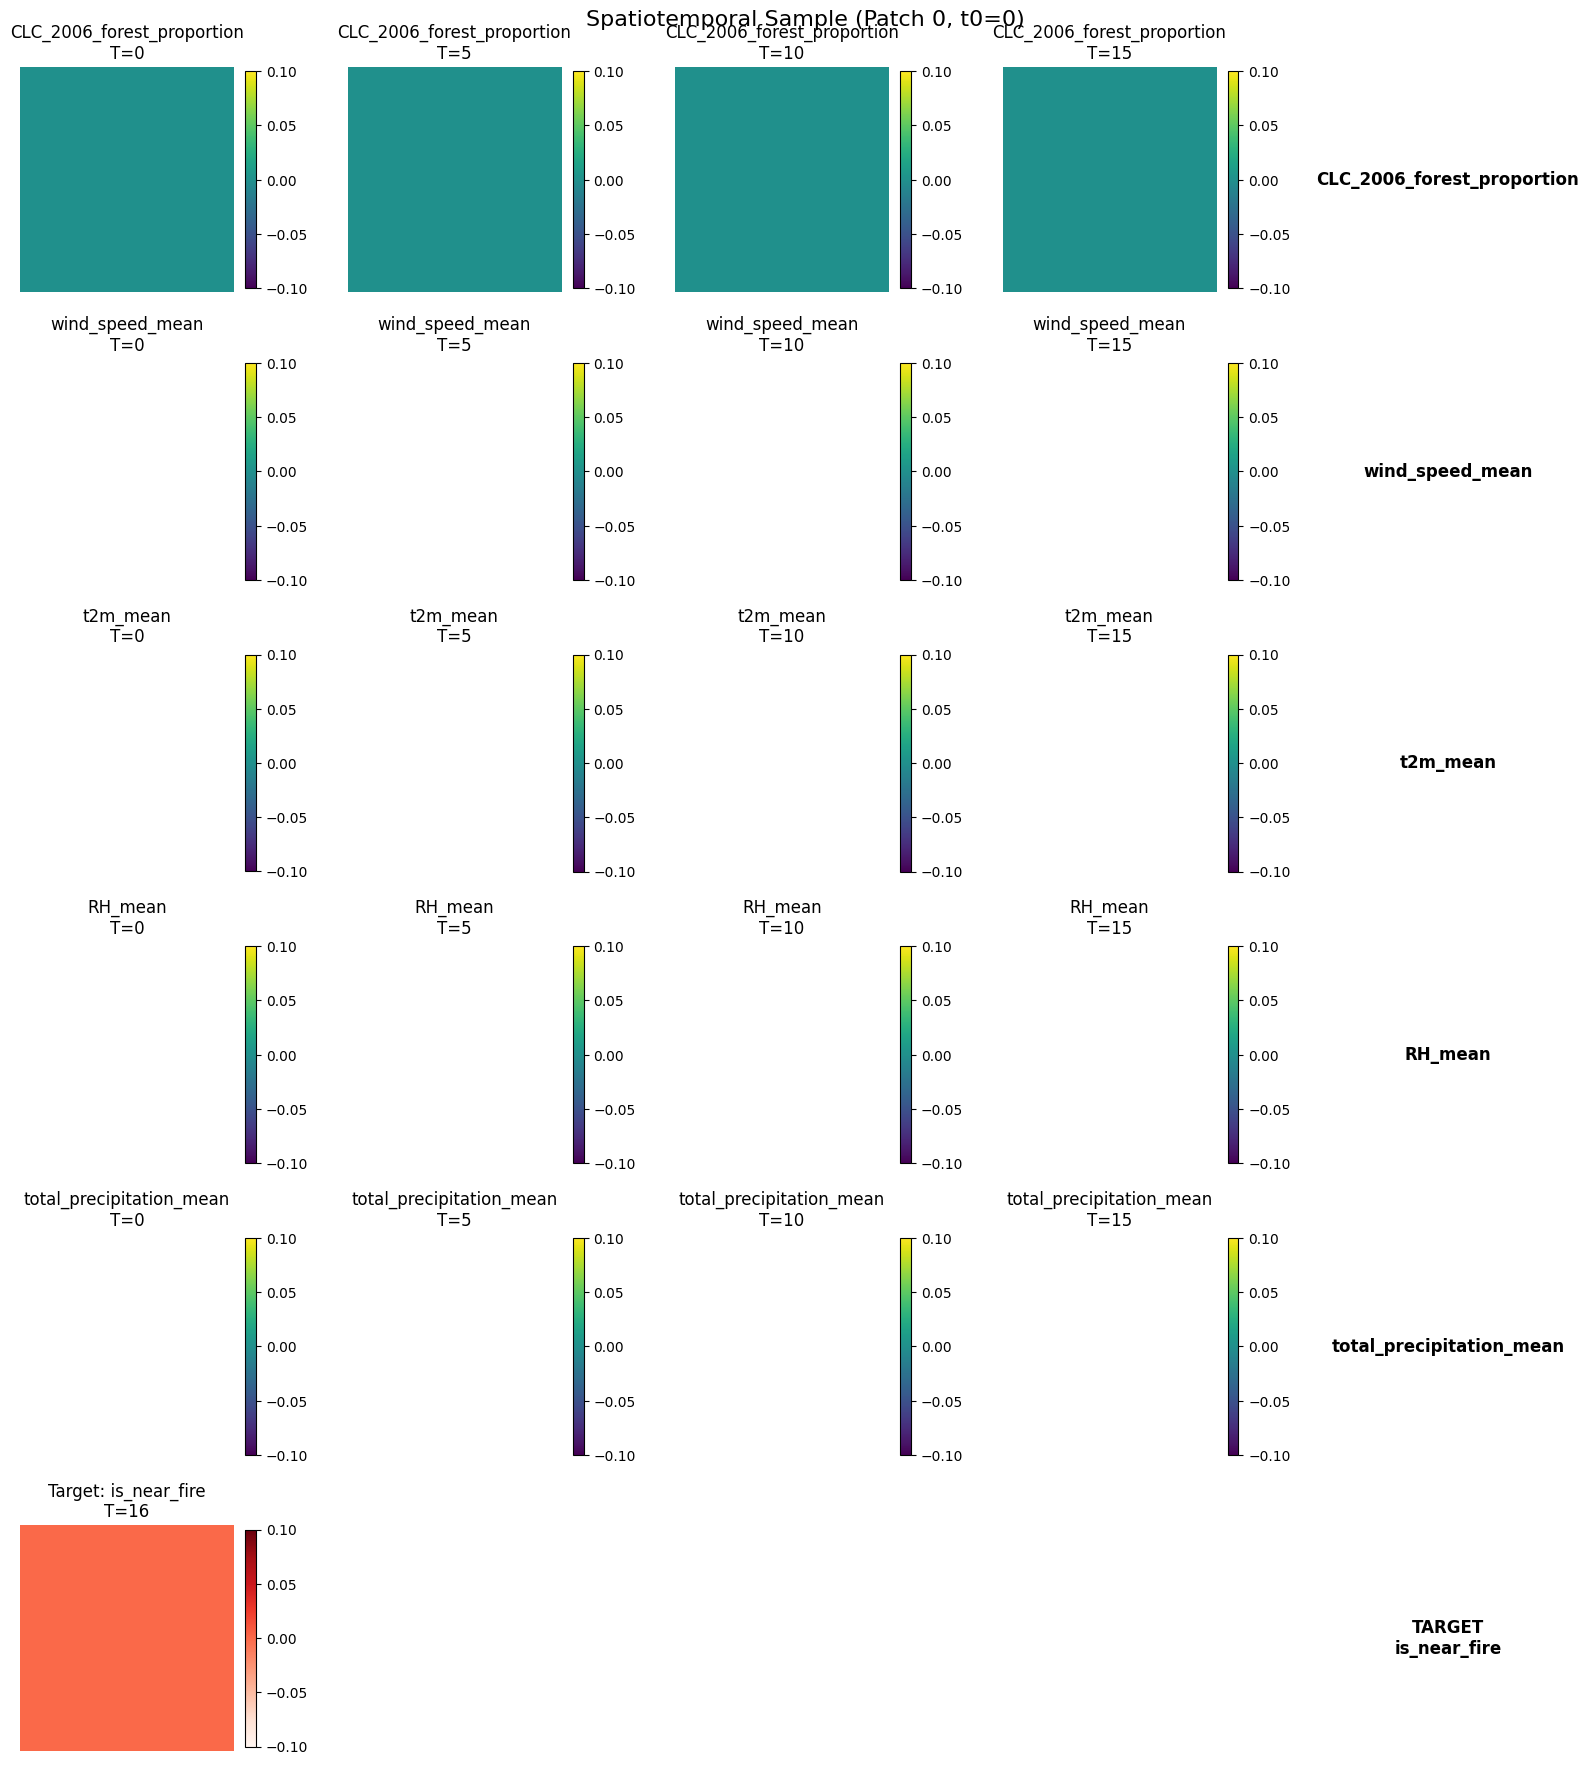

In [14]:
# Step 2: Visualize the Data
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_spatiotemporal_batch(batch, sample_idx=0, time_steps_to_show=4):
    """
    Visualize a spatiotemporal sample from the batch
    """
    inputs = batch["inputs"][sample_idx]    # (T, C, H, W)
    target = batch["target"][sample_idx]    # (H, W)
    t0 = batch["t0"][sample_idx].item()
    
    T, C, H, W = inputs.shape
    
    # Select time steps to visualize (evenly spaced)
    time_indices = np.linspace(0, T-1, time_steps_to_show, dtype=int)
    
    # Create subplot grid
    fig, axes = plt.subplots(C + 1, time_steps_to_show + 1, 
                           figsize=(16, 3*(C+1)))
    
    if C == 1:  # Handle single channel case
        axes = axes.reshape(1, -1)
    
    # Plot input channels across time
    for c in range(C):
        var_name = dataset.predictor_variables[c]
        
        for i, t in enumerate(time_indices):
            ax = axes[c, i]
            
            data = inputs[t, c, :, :].numpy()
            im = ax.imshow(data, cmap='viridis', aspect='auto')
            ax.set_title(f'{var_name}\nT={t0+t}')
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Show channel name in last column
        axes[c, -1].text(0.5, 0.5, var_name, ha='center', va='center',
                         fontsize=12, weight='bold', 
                         transform=axes[c, -1].transAxes)
        axes[c, -1].axis('off')
    
    # Plot target in bottom row
    for i in range(time_steps_to_show):
        ax = axes[-1, i]
        if i == 0:  # Only show target in first position
            im = ax.imshow(target.numpy(), cmap='Reds', aspect='auto')
            ax.set_title(f'Target: {dataset.target_variable}\nT={t0+T}')
            plt.colorbar(im, ax=ax, fraction=0.046)
        ax.axis('off')
    
    # Target label
    axes[-1, -1].text(0.5, 0.5, f'TARGET\n{dataset.target_variable}', 
                     ha='center', va='center', fontsize=12, weight='bold',
                     transform=axes[-1, -1].transAxes)
    axes[-1, -1].axis('off')
    
    plt.suptitle(f'Spatiotemporal Sample (Patch {sample_idx}, t0={t0})', 
                fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Visualize first sample
visualize_spatiotemporal_batch(batch, sample_idx=0, time_steps_to_show=4)

In [16]:
# Step 1: Diagnose the dataset structure
print("=== DATASET DIAGNOSIS ===")

ds = xr.open_dataset(DATASET_PATH)
print(f"Dataset dimensions: {dict(ds.sizes)}")
print(f"Available variables: {list(ds.data_vars)[:10]}...")  # First 10

# Check your specific variables
problem_vars = ["CLC_2006_forest_proportion", "wind_speed_mean", "t2m_mean", "RH_mean", "total_precipitation_mean", "is_near_fire"]

for var in problem_vars:
    if var in ds.data_vars:
        var_data = ds[var]
        print(f"\n{var}:")
        print(f"  Dimensions: {var_data.dims}")
        print(f"  Shape: {var_data.shape}")
        print(f"  Data type: {var_data.dtype}")
        
        # Check a small sample
        if len(var_data.dims) == 3:  # (time, y, x)
            sample = var_data.isel(time=0, y=slice(400, 410), x=slice(400, 410)).compute()
        elif len(var_data.dims) == 2:  # (y, x)
            sample = var_data.isel(y=slice(400, 410), x=slice(400, 410)).compute()
        else:
            sample = var_data.isel({dim: 0 for dim in var_data.dims}).compute()
            
        print(f"  Sample range: {float(sample.min())} to {float(sample.max())}")
        print(f"  Sample NaN count: {sample.isnull().sum().item()}")
    else:
        print(f"\n❌ {var}: NOT FOUND")

=== DATASET DIAGNOSIS ===
Dataset dimensions: {'y': 920, 'x': 1188, 'time': 6241}
Available variables: ['x_index', 'y_index', 'is_spain', 'is_fire', 'is_near_fire', 'x_coordinate', 'y_coordinate', 'is_sea', 'is_waterbody', 'AutonomousCommunities']...

CLC_2006_forest_proportion:
  Dimensions: ('y', 'x')
  Shape: (920, 1188)
  Data type: float32
  Sample range: 0.0 to 0.9900000095367432
  Sample NaN count: 0

wind_speed_mean:
  Dimensions: ('time', 'y', 'x')
  Shape: (6241, 920, 1188)
  Data type: float32
  Sample range: 1.3765692710876465 to 1.6160516738891602
  Sample NaN count: 0

t2m_mean:
  Dimensions: ('time', 'y', 'x')
  Shape: (6241, 920, 1188)
  Data type: float32
  Sample range: 3.20233154296875 to 3.744049072265625
  Sample NaN count: 0

RH_mean:
  Dimensions: ('time', 'y', 'x')
  Shape: (6241, 920, 1188)
  Data type: float32
  Sample range: 83.0174331665039 to 84.66919708251953
  Sample NaN count: 0

total_precipitation_mean:
  Dimensions: ('time', 'y', 'x')
  Shape: (6241, 